# Importing Module

In [1]:
#kplr used to import koi data easier
import kplr
client = kplr.API()

#used to open .fits files
import pyfits
# import astropy

#Used for Plotting
#Experimenting with this instead of using matplot.lib
from bokeh.plotting import figure, show, output_file,output_notebook
#Allows for viewing of plots on jupyter notebooks
output_notebook()

#For Maximum Likelihood
from scipy import optimize

#Used for scientific computing
import numpy as np

#For making copies of data
import copy

#Needed to correct median with 'nan' data points
import math

#For Periodogram
from gatspy.periodic import LombScargleFast

#Importing and notebook setup
%matplotlib inline

#For Plotting
import matplotlib.pyplot as plt

#adjusting data using pyke
import pyke

#for astro constants
from astropy.constants import *

#needed for bls function
import math

Loading BokehJS ...

# Making useful functions

Removing "nan" Flux Data Points

In [2]:
#Removes nan data points
def remove_nan(datax,datay):
    #array of nan points location in flux array
    nan_points=np.array([])
    
    #finds points that have nan as data point
    for j in range(0,len(datax)-1):
        if math.isnan(datay[j])==True:
            nan_points = np.append(nan_points,j)
    
    #deletes the points with nan and correspoding time
    datax = np.delete(datax,nan_points)
    datay = np.delete(datay,nan_points)
        
    return(datax,datay)

Removing Outliers

In [3]:
#datax - time data
#datay - flux data
#cutoff - flux larger than this value get removed
def remove_outlier(datax, datay, cutoff):
    outlier_points = np.array([])
    
    for i in range(0,len(datay)-1):
        if f[i]>cutoff:
            outlier_points = np.append(outlier_points,i)

    print outlier_points
    #deletes the points with nan and correspoding time
    datax = np.delete(datax,outlier_points)
    datay = np.delete(datay,outlier_points)
    
    return (datax, datay)

Lists all Outliers

In [4]:
#datay - flux
#maxdelta - max change from points to not be considered an outlier
def list_outliers(datay, maxdelta):
    
    outlier_points = np.array([])
    for i in range(1,len(datay)):
        delta = datay[i] - datay[i-1]
        
        if delta > maxdelta:
            a = int(i)
            outlier_points = np.append(outlier_points,a)
    
    return outlier_points

Periodograms

In [5]:
######Lomb-Scargle Periodogram##########

# Used to find periodic activity of star 
### Works only if you remove "nan" data points
#1st argument: time data
#2nd argument: flux data
#3rd argument: range minimum for finding period
#4th argument: range maximum for finding period
#5th argument: time between data points
def periodogram(datax, datay, min_per, max_per, nyquist):
    #finding periodogram
    model = LombScargleFast().fit(datax, datay)
    period, power = model.periodogram_auto(nyquist_factor=nyquist)

    #Plotting
    periodogram = figure(
        x_axis_label="Period",
        x_axis_type="log",
        y_axis_label="Period",
        tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

    #adding x and y data for plot
    periodogram.line(period,power)

    #showing results
    show(periodogram)

    # set range and find period
    model.optimizer.period_range=(min_per, max_per)
    period = model.best_period
    print("period = {0}".format(period))
    return period

In [6]:
#My own method of finding periods
#### Only works for clear periodiotic drops in flux
### Step 1: Make a cut_off and only look at that data
### Step 2: Find min flux of each trough
### Step 3: Find the avg. time diff between each local min
###Still need to makes this plot into a function and then will place it up above

#1st Argument: Flux Data
#2nd Argument: cut_off for troughs that get counted

def find_period(flux,cut_off):
    # cut_off is the max the point can be to pass the filter
    # f_change - change in flux from cutoff

    min_f = np.array([])
    min_t = np.array([])

    #Step 1: filters data to just the points below the cut_off
    for i in range(0,len(flux)):
        f_change = flux[i] - cut_off

        #checks if it's lower than cut off
        if f_change < 0:
            min_f = np.append(min_f,[flux[i]])
            min_t = np.append(min_t,[t[i]])

    # print min_f
    # print min_t

    #local_min - lowest point of troughs place holder
    #check - checks to see if new point is lower than previous local_min
    local_min = min_f[0]
    ndata = 0
    troughs_f = np.array([])
    troughs_t = np.array([])

    #Step 2: filters to just show only the lowest point of each trough
    for i in range(0,len(min_f)-1):
        t_change = min_t[i+1] - min_t[i]
        check = min_f[i]
        # checks if it's lower than previous local_min
        if check < local_min:
            local_min = check
            ndata = i

        #documents lowest point of each trough and resets check for next trough
        #t_change: checks time seperation between points to distinguish two seperate troughs, 
        #          can also be seen as min period it looks for
        if t_change > .5 or i > len(min_f)-3:
            troughs_f = np.append(troughs_f, [local_min])
            troughs_t = np.append(troughs_t, [min_t[ndata]])
            local_min = cut_off

    # print 'The min of each flux trough: ', troughs_f
    # print 'The corresponding time for each trough: ' ,troughs_t

    all_periods = np.array([])

    #Step 3: finding average change in time from each trough
    for i in range(0,len(troughs_t)-1):
        period = troughs_t[i+1]-troughs_t[i]
        all_periods = np.append(all_periods,period)

    avg_period = np.mean(all_periods,dtype=np.float64)
    print 'All periods: ', all_periods
    print 'Avg. period: ', avg_period, ' days.'

    return avg_period

BLS Function

In [7]:
#### Copying code from: https://ridlow.wordpress.com/category/ipython-notebook/

# t - time is an N-dimensional array of timestamps for the light curve,
# x - flux is the N-dimensional light curve array,
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nb is the number of bins to use in the folded light curve,
# nf is the number of frequency bins to test,

def bls(t, x, qmi, qma, fmin, df, nf, nb):
    """Frist trial, BLS algorithm, only minor modification from author's code"""
    
    n = len(t); rn = len(x)
    #! use try
    if n != rn:
        print "Different size of array, t and x"
        return 0

    rn = float(rn) # float of n

    minbin = 5
    nbmax = 2000
    if nb > nbmax:
        print "Error: NB > NBMAX!"
        return 0

    tot = t[-1] - t[0] # total time span

    if fmin < 1.0/tot:
        print "Error: fmin < 1/T"
        return 0

    # parameters in binning (after folding)
    kmi = int(qmi*nb) # nb is number of bin -> a single period
    if kmi < 1: 
        kmi = 1
    kma = int(qma*nb) + 1
    kkmi = rn*qmi # to check the bin size
    if kkmi < minbin: 
        kkmi = minbin

    # For the extension of arrays (edge effect: transit happen at the edge of data set)
    nb1 = nb + 1
    nbkma = nb + kma
        
    # Data centering
    t1 = t[0]
    u = t - t1
    s = np.mean(x) # ! Modified
    v = x - s

    bpow = 0.0
    p = np.zeros(nf)
    # Start period search
    for jf in range(nf):
        f0 = fmin + df*jf # iteration in frequency not period
        p0 = 1.0/f0

        # Compute folded time series with p0 period
        ibi = np.zeros(nbkma)
        y = np.zeros(nbkma)
        for i in range(n):
            ph = u[i]*f0 # instead of t mod P, he use t*f then calculate the phase (less computation)
            ph = ph - int(ph)
            j = int(nb*ph) # data to a bin 
            ibi[j] = ibi[j] + 1 # number of data in a bin
            y[j] = y[j] + v[i] # sum of light in a bin
        
        # Extend the arrays  ibi()  and  y() beyond nb by wrapping
        for j in range(nb1, nbkma):
            jnb = j - nb
            ibi[j] = ibi[jnb]
            y[j] = y[jnb]

        # Compute BLS statictics for this trial period
        power = 0.0

        for i in range(nb): # shift the test period
            s = 0.0
            k = 0
            kk = 0
            nb2 = i + kma
            # change the size of test period (from kmi to kma)
            for j in range(i, nb2): 
                k = k + 1
                kk = kk + ibi[j]
                s = s + y[j]
                if k < kmi: continue # only calculate SR for test period > kmi
                if kk < kkmi: continue # 
                rn1 = float(kk)
                powo = s*s/(rn1*(rn - rn1))
                if powo > power: # save maximum SR in a test period
                    power = powo # SR value
                    jn1 = i # 
                    jn2 = j
                    rn3 = rn1
                    s3 = s

        power = math.sqrt(power)
        p[jf] = power

        if power > bpow:
            bpow = power # Save the absolute maximum of SR
            in1 = jn1
            in2 = jn2
            qtran = rn3/rn
            # depth = -s3*rn/(rn3*(rn - rn3))
            # ! Modified
            high = -s3/(rn - rn3)
            low = s3/rn3
            depth = high - low
            bper = p0
    
    # ! add
    sde = (bpow - np.mean(p))/np.std(p) # signal detection efficiency

    return bpow, in1, in2, qtran, depth, bper, sde, p, high, low

# Beginning to Look at Data

Importing Data

In [8]:
# Find a KOI.
koi = client.koi(265.01)

#period, period error (postive & negative)
# print 'Period w/ errors: ',(koi.koi_period, koi.koi_period_err1, koi.koi_period_err2)

# This KOI has an associated star.
# star = koi.star
# print star
# print "Associated Star Temperature: ",(star.kic_teff)

#Download the lightcurves for this KOI.
lightcurves = koi.get_light_curves(short_cadence=False)
# for lc in lightcurves:
#     print (lc.filename)
print "Kepler ID ", koi.kepid

Kepler ID  12024120


Getting Like Curve Data

In [9]:
# Loop over the datasets and read in the data.
#Open the FITS data file and return the ``pyfits.HDUList``. This will
#download the file if it isn't already saved locally.
datacol = "PDCSAP_FLUX"
errcol = "PDCSAP_FLUX_ERR"
time, flux, ferr, quality = [], [], [], []
for lc in lightcurves:
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        #can also append "SAP_Flux
        hdu_data = f[1].data
        time.append(hdu_data["time"])
        flux.append(hdu_data[datacol])
        ferr.append(hdu_data[errcol])
        quality.append(hdu_data["sap_quality"])

Initial Plot of Data

In [11]:
# Time (BJD - 2454833)
#Flux (e-/sec) + ____e+4
#Which quarter do you want to look at?
quarter1 = 9
quarter2 = 10
t1 = time[quarter1]
t2 = time[quarter2]
f1 = flux[quarter1]
f2 = flux[quarter2]
BJD = 245833
#Following Labels are used for all graphs
x_label = 'Time (BJD - %d)' %BJD
y_label = 'Flux(e-/sec)'
title = 'Kepler ID: %d'%(koi.kepid)


#Creating new plot with title and axis labels
#Plot is an object
lc_plot_265 = figure(
    title=title, 
    x_axis_label=x_label,
    y_axis_label=y_label,
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data for plot
legend1 = 'Quarter %d' % quarter1
legend2 = 'Quarter %d' % quarter2
lc_plot_265.circle(t1, f1,legend=legend1)
lc_plot_265.circle(t2, f2,color='red',legend=legend2)

#showing results
show(lc_plot_265)

Removing all nan values from flux data

In [21]:
t1_no_nan, f1_no_nan =remove_nan(t1,f1)
t2_no_nan, f2_no_nan =remove_nan(t2,f2)

[  906.86563898   906.8860732    906.90650753 ...,  1000.22769555
  1000.24812884  1000.26856202]
[ 808.53625314  808.55668705  808.57712095 ...,  905.88482844  905.90526257
  905.9256969 ]


## Method 1: Detrending Method, Running Average

Step 1: cleaning data, remove outliers and nan points

In [22]:
maxdelta = 50
list1_outlier = list_outliers(f1_no_nan,maxdelta)
# print list_outlier
f1_no_outlier = np.delete(f1_no_nan,list1_outlier)
t1_no_outlier = np.delete(t1_no_nan,list1_outlier)

list2_outlier = list_outliers(f2_no_nan,maxdelta)
# print list_outlier
f2_no_outlier = np.delete(f2_no_nan,list2_outlier)
t2_no_outlier = np.delete(t2_no_nan,list2_outlier)

In [23]:
#Plot is an object
lc_no_outlier_265 = figure(
    title= title, 
    x_axis_label= x_label,
    y_axis_label=y_label,
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data for plot
lc_no_outlier_265.circle(t1,f1,legend=legend1,fill_alpha = .2,line_alpha=.2)
lc_no_outlier_265.circle(t1_no_outlier, f1_no_outlier,legend='Cleaned Flux Quater %d' %quarter1,color='orange')

lc_no_outlier_265.circle(t2,f2,legend=legend2,fill_alpha = .2,line_alpha=.2, color = 'green')
lc_no_outlier_265.circle(t2_no_outlier, f2_no_outlier,legend='Cleaned Flux Quater %d' %quarter2,color='red')
show(lc_no_outlier_265)

Step 2:Normalize data

In [31]:
median1= (len(f1_no_outlier))/2
f1_median =np.float64( "%f" % np.median(f1_no_outlier))
f1_mean = np.mean(f1_no_outlier,dtype=np.float64)

#make changes here if you want running average or median
f1_normalized = f1_no_outlier/f1_mean

median2= (len(f2_no_outlier))/2
f2_median =np.float64( "%f" % np.median(f2_no_outlier))
f2_mean = np.mean(f2_no_outlier,dtype=np.float64)

#make changes here if you want running average or median
f2_normalized = f2_no_outlier/f2_mean

#combining data from two quarters
f_normalized = np.append(f1_normalized, f2_normalized)
t_no_outlier = np.append(t1_no_outlier, t2_no_outlier)

In [39]:
#Plot is an object
lc_normal_265 = figure(
    title= title, 
    x_axis_label= x_label,
    y_axis_label=y_label,
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data for plot
lc_normal_265.circle(t1_no_outlier, f1_normalized,legend='Normalized Flux Q%d'%quarter1)
lc_normal_265.circle(t2_no_outlier, f2_normalized,legend='Normalized Flux Q%d'%quarter2,color='red')
# lc_normal_265.circle(t_no_outlier, f_normalized,legend='Normalized Flux Q%d & Q%d'%(quarter1,quarter2),color='green')


# lc_normal_265.circle(t,f,legend=legend,fill_alpha = .2,line_alpha=.2)
show(lc_normal_265)

Step 3: Running Average or Median

In [40]:
npts = int(len(f_normalized))
print np.sqrt(npts)

94.3239100123


In [43]:
n = 95 #odd number around value of sqrt above
# c = copy.copy(f_no_outlier)
c = copy.copy(f_normalized)


for i in range(0,len(f_normalized)-(n)+1):
    low_r = i
    high_r = low_r + n
    center = i + (n+1)/2
#     data = f_no_outlier[low_r:high_r]
    data = f_normalized[low_r:high_r]
    running = np.mean(data,dtype=np.float64) #running average
#     running = np.float64( "%f" % np.median(data))
    c[center] = running

In [45]:
low_r = (n+1)/2
# high_r = len(f_no_outlier)-low_r
# f_detrend = (f_no_outlier[low_r:high_r]/ c[low_r:high_r])
low_r = (n+1)/2
high_r = len(f_normalized)-low_r
f_detrend = (f_normalized[low_r:high_r]/ c[low_r:high_r])
t_detrend = t_no_outlier[low_r:high_r]

In [50]:
#Plot is an object
lc_detrend_265 = figure(
    title= title, 
    x_axis_label= x_label,
    y_axis_label='Flux',
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data for plot
lc_detrend_265.circle(t_no_outlier,f_normalized,legend='Normalized Flux',fill_alpha = .1,line_alpha=.1, color = 'red')
lc_detrend_265.circle(t_detrend,f_detrend ,legend='Detrend Flux',color='green')
show(lc_detrend_265)

Step 4: Periodogram and BLS

In [52]:
#1st argument: time data
#2nd argument: flux data
#3rd argument: minimum period
#4th argument: max period
#5th argument: time between data points
min_period = .1
max_period = (max(t_no_outlier) - min(t_no_outlier))/3.
# max_period = 4
nyquist = .02 #30min flux samples
period1 = periodogram(t_detrend,f_detrend,min_period,max_period,nyquist)

Finding optimal frequency:
 - Estimated peak width = 0.0331
 - Using 5 steps per peak; omega_step = 0.00662
 - User-specified period range:  0.1 to 64
 - Computing periods at 9474 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 4.14510130587


In [54]:
# t_bls - time is an N-dimensional array of timestamps for the light curve,
# f_bls - flux is the N-dimensional light curve array,
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nb is the number of bins to use in the folded light curve,
# nf is the number of frequency bins to test,
qmi = 0.06 #.02 is about 30 mins
qma = 0.3
fmin = round(1./max_period,2) #freq = 1/period
fmin = 1/4.
df = 0.001 
nf = 1000
nb = 200

t_bls = t_detrend
f_bls = f_detrend
res = bls(t_bls, f_bls, qmi, qma, fmin, df, nf, nb)
print "Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
"\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6]


print "correct period: ", 3.568065

Best SR:  1.01388657933e-05 
Ingress:  127 
Egress:  139 
q:  0.0645381206681 
Depth:  4.12637002356e-05 
Period:  3.57142857143 
SDE:  10.6211898031
correct period:  3.568065


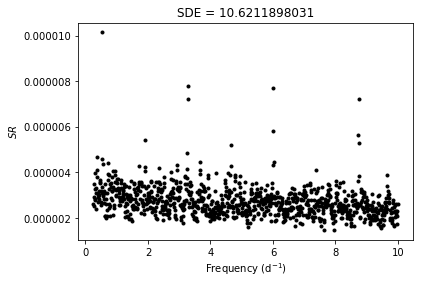

In [55]:
fmax = round(1./min_period,2) #freq = 1/period
steps = (fmax - fmin)/nf
freq = np.arange(fmin, fmax,steps)
plt.plot(freq, res[7], 'k.')
plt.title("SDE = {0}".format(res[6]))
plt.xlabel(r"Frequency (d$^{-1}$)")
plt.ylabel(r"$SR$")

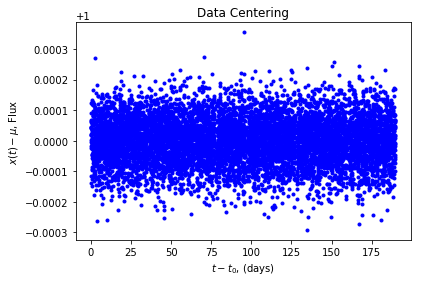

In [56]:
t1 = t_bls[0]
#subtracts t0 from all times
u = t_bls - t1
#avg. flux
s = np.mean(f_bls)

#each flux point subtracted from mean of flux
# v = f_bls - s

## adjustment
#Better cause it shows percentage of change
v = f_bls/s

#plotting data
plt.plot(u, v, 'b.')
plt.title("Data Centering")
plt.xlabel(r"$t - t_0$, (days)")
plt.ylabel(r"$x(t) - \mu$, Flux")

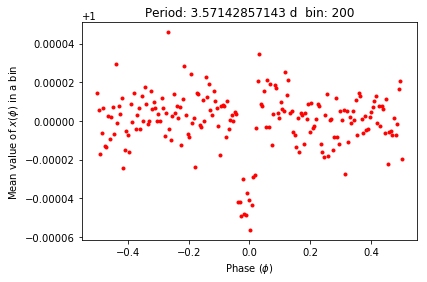

In [57]:
#converting period to freq
f0 = 1.0/(res[5]) #  freq = 1/T
nbin = nb # number of bin
n = len(t_bls)
ibi = np.zeros(nbin)
y = np.zeros(nbin)
phase = np.linspace(-0.5, 0.5, nbin) 

#this loop folds the data for each phase
for i in range(n):
    ph = u[i]*f0 #divides by period
    ph = ph - int(ph) # removes integer, ex. 5.2 ->> .2
    
    #creates mean value of flux over time in a bin
    j = int(nbin*ph) # data to a bin 
    ibi[j] = ibi[j] + 1.0 # number of data in each bin
    y[j] = y[j] + v[i] # sum of light in a bin
    
mean_bin = y/ibi
through_center = np.argmin(mean_bin) #finds index of 
diff_center = nbin/2 - through_center
mean_bin = np.roll(mean_bin, diff_center) #centers data

plt.plot(phase, mean_bin, 'r.')
plt.title("Period: {0} d  bin: {1}".format(res[5], nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")


Trough Value:  0.999943708832


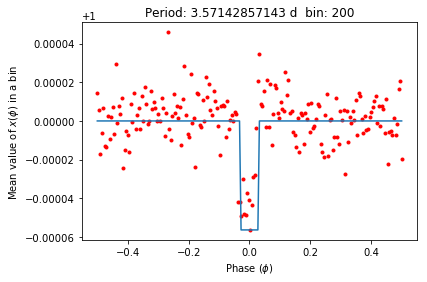

In [60]:
plt.plot(phase, mean_bin, 'r.')

#bls fit
fite = np.ones(nbin) # H
# res[8] = high, res [9] = low
#uses ingress(res[1]), and engress(res[2]), to model expected results
engress = nbin/2 + (res[2] - res[1])/2 # engress bin number
ingress = nbin/2 - (res[2] - res[1])/2 # ingress bin number
trough = np.min(mean_bin) #model of the dip in the trough
fite[ingress:engress] = trough # adding model depth
    
print "Trough Value: ",trough
#added to adjust for new y axis scale
# fite = fite/s + 1

plt.plot(phase, fite)
plt.title("Period: {0} d  bin: {1}".format(res[5], nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

## Radius of Planet

In [62]:
R_star = 1.35*R_sun # Star we are looking at
depth = 1-np.abs(trough) #depth of trough
R_planet = R_star*np.sqrt(depth) #finding radius of star
print R_planet/R_earth, 'Earth Radii'
print 'True answer: 1.29 Earth Radii'

1.10449118574 Earth Radii
True answer: 1.29 Earth Radii


## Method 2: Pyke Smoothing

Using pyke to median smooth all .fits lightcurves

In [63]:
# ###NOTE: if files exist already then delete or comment this part out


# #outputs median smooth .fits files
# for i in range(0,len(lightcurves)):

#     output_file = 'c:/Users/rscsa/Research/radvel-master/%d/smooth fits/%d_%d_%s'%(koi.kepid,koi.kepid,i,datacol)
#     print "Smoothing Quarter %d of Data:"%i
#     pyke.kepsmooth(lightcurves[i].filename,output_file,datacol=datacol)

Extracts all data from .fits files

In [64]:
time_smooth, flux_smooth, ferr_smooth, quality_smooth = [], [], [], []
for i in range(0,len(lightcurves)):
    output_file = 'c:/Users/rscsa/Research/radvel-master/%d/smooth fits/%d_%d_%s'%(koi.kepid,koi.kepid,i,datacol)

    hdulist = pyfits.open(output_file)
    # hdulist.info()
    hdu_data = hdulist[1].data
    
    time_smooth.append(hdu_data["time"])
    flux_smooth.append(hdu_data[datacol])
    ferr_smooth.append(hdu_data["%s_ERR"%datacol])
    quality_smooth.append(hdu_data["sap_quality"]) 

Plotting Pyke Smoothing

In [77]:
# Time (BJD - 2454833)
#Flux (e-/sec) + ____e+4
#Which quarter do you want to look at?
t1_smooth = time_smooth[quarter1]
f1_smooth = flux_smooth[quarter1]
t2_smooth = time_smooth[quarter2]
f2_smooth = flux_smooth[quarter2]

#Creating new plot with title and axis labels
#Plot is an object
lc_pykesmooth_265 = figure(
    title=title, 
    x_axis_label=x_label,
    y_axis_label=y_label,
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data and legend for plot
lc_pykesmooth_265.circle(t1_smooth, f1_smooth,legend="Pyke Smooth Q%d"% quarter1)
lc_pykesmooth_265.circle(t2_smooth, f2_smooth,legend="Pyke Smooth Q%d" % quarter2,color="red")

# lc_pykesmooth_265.circle(t,f,legend=legend,fill_alpha = .2,line_alpha=.2)

#showing results
show(lc_pykesmooth_265)

In [78]:
median1= (len(f1_smooth))/2
f1_smooth_median =np.float64( "%f" % np.median(f1_smooth))
f1_smooth_mean = np.mean(f1_smooth,dtype=np.float64)

#make changes here if you want running average or median
f1_smooth_normalized = f1_smooth/f1_smooth_mean

median2= (len(f2_smooth))/2
f2_smooth_median =np.float64( "%f" % np.median(f2_smooth))
f2_smooth_mean = np.mean(f2_smooth,dtype=np.float64)

#make changes here if you want running average or median
f2_smooth_normalized = f2_smooth/f2_smooth_mean

#combining data from two quarters
f_smooth_normalized = np.append(f1_smooth_normalized, f2_smooth_normalized)
t_smooth_no_outlier = np.append(t1_smooth, t2_smooth)

In [85]:
#Creating new plot with title and axis labels
#Plot is an object
lc_pyke_normalized_265 = figure(
    title=title, 
    x_axis_label=x_label,
    y_axis_label=y_label,
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data and legend for plot
lc_pyke_normalized_265.circle(t1_smooth, f1_smooth_normalized,legend="Pyke Normalized Q%d"% quarter1)
lc_pyke_normalized_265.circle(t2_smooth, f2_smooth_normalized,legend="Pyke Normalized Q%d" % quarter2,color="red")

# lc_pykesmooth_265.circle(t,f,legend=legend,fill_alpha = .2,line_alpha=.2)

#showing results
show(lc_pyke_normalized_265)

In [86]:
period1 = periodogram(t_smooth_no_outlier,f_smooth_normalized,min_period,max_period,nyquist)

Finding optimal frequency:
 - Estimated peak width = 0.0328
 - Using 5 steps per peak; omega_step = 0.00655
 - User-specified period range:  0.1 to 64
 - Computing periods at 9573 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 11.8484927003


Box Least Square

In [87]:
# median_smooth_file = 'c:/Users/rscsa/Research/radvel-master/%d/smooth fits/%d_%d_%s'%(koi.kepid,koi.kepid,quarter,datacol)
# output_file = 'c:/Users/rscsa/Research/radvel-master/%d/bls fits/%d_%d_%s'%(koi.kepid,koi.kepid,quarter,'bls')
# print "BLS on Quarter %d of Data:"%quarter

# # pyke.kepbls(lightcurves[quarter].filename,output_file,datacol=datacol,errcol=errcol)
# pyke.kepbls(median_smooth_file,output_file,datacol=datacol,errcol=errcol)

In [88]:
# t_bls - time is an N-dimensional array of timestamps for the light curve,
# f_bls - flux is the N-dimensional light curve array,
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nb is the number of bins to use in the folded light curve,
# nf is the number of frequency bins to test,

t_bls = t_smooth_no_outlier
f_bls = f_smooth_normalized
res = bls(t_bls, f_bls, qmi, qma, fmin, df, nf, nb)
print "Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
"\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6]


print "correct period: ", 3.568065

Best SR:  4.82898269971e-06 
Ingress:  130 
Egress:  190 
q:  0.305712076014 
Depth:  1.04816474142e-05 
Period:  3.10559006211 
SDE:  5.34988609146
correct period:  3.568065


Plotting BLS Results

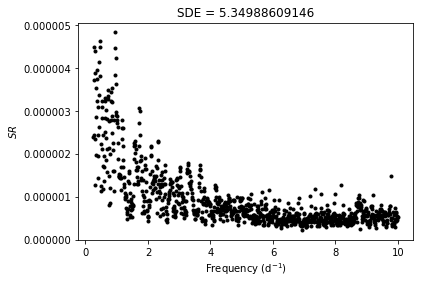

In [89]:
fmax = round(1./min_period,2) #freq = 1/period
steps = (fmax - fmin)/nf
freq = np.arange(fmin, fmax,steps)
plt.plot(freq, res[7], 'k.')
plt.title("SDE = {0}".format(res[6]))
plt.xlabel(r"Frequency (d$^{-1}$)")
plt.ylabel(r"$SR$")

## Data centering
Divide flux with the average value

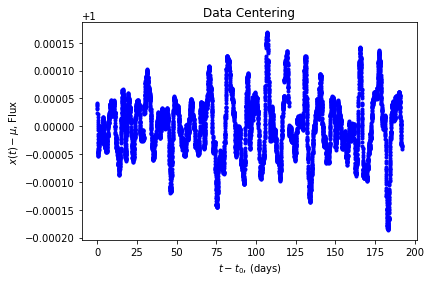

In [90]:
t1 = t_bls[0]
#subtracts t0 from all times
u = t_bls - t1
#avg. flux
s = np.mean(f_bls)

#each flux point subtracted from mean of flux
# v = f_bls - s

## adjustment
#Better cause it shows percentage of change
v = f_bls/s

#plotting data
plt.plot(u, v, 'b.')
plt.title("Data Centering")
plt.xlabel(r"$t - t_0$, (days)")
plt.ylabel(r"$x(t) - \mu$, Flux")

## Folded and binned
If we fold the data with correct period and binned to 300 bins

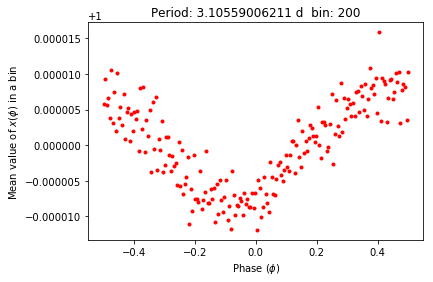

In [91]:
#converting period to freq
f0 = 1.0/(res[5]) #  freq = 1/T
nbin = nb # number of bin
n = len(t_bls)
ibi = np.zeros(nbin)
y = np.zeros(nbin)
phase = np.linspace(-0.5, 0.5, nbin) 

#this loop folds the data for each phase
for i in range(n):
    ph = u[i]*f0 #divides by period
    ph = ph - int(ph) # removes integer, ex. 5.2 ->> .2
    
    #creates mean value of flux over time in a bin
    j = int(nbin*ph) # data to a bin 
    ibi[j] = ibi[j] + 1.0 # number of data in each bin
    y[j] = y[j] + v[i] # sum of light in a bin
    
mean_bin = y/ibi
through_center = np.argmin(mean_bin) #finds index of 
diff_center = nbin/2 - through_center
mean_bin = np.roll(mean_bin, diff_center) #centers data

plt.plot(phase, mean_bin, 'r.')
plt.title("Period: {0} d  bin: {1}".format(res[5], nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

## Fitted to the BLS result
Folded with correct trial period and fit it with the BLS results.

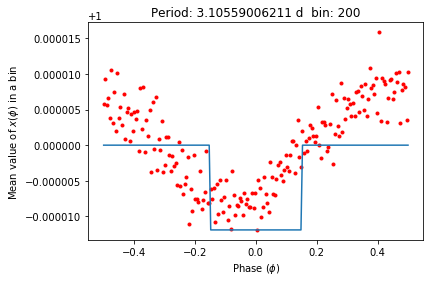

In [92]:
plt.plot(phase, mean_bin, 'r.')

#bls fit
fite = np.ones(nbin) # H
# res[8] = high, res [9] = low
#uses ingress(res[1]), and engress(res[2]), to model expected results
engress = nbin/2 + (res[2] - res[1])/2 # engress bin number
ingress = nbin/2 - (res[2] - res[1])/2 # ingress bin number
trough = np.min(mean_bin) #model of the dip in the trough
fite[ingress:engress] = trough # adding model depth

#added to adjust for new y axis scale
# fite = fite/s + 1

plt.plot(phase, fite)
plt.title("Period: {0} d  bin: {1}".format(res[5], nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

# Ignore Everything Below Here

In [ ]:
# import pandas as pd
# data= pd.read_csv("KOI-265.csv")
# t_detrend1 = np.array(data.BJD)
# f_detrend1= np.array(data.Detrend)


In [ ]:
# #Plot is an object
# lc_detrend_265 = figure(
#     title= title, 
#     x_axis_label= x_label,
#     y_axis_label=y_label,
#     tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

# #adding x and y data for plot
# lc_detrend_265.circle(t_detrend1, f_detrend1,legend='Detrend Flux',color='green')
# # lc_detrend_265.circle(t_no_outlier,normal_normalized,legend='Normalized Flux',fill_alpha = .2,line_alpha=.2)
# show(lc_detrend_265)

In [ ]:
# #using pyfits to open a quarter of data as .fits file
# pyfits.open('c:/Users/rscsa/.kplr/data/lightcurves/010874614/kplr010874614-2009131105131_llc.fits')
# print pyfits.hdu.image.PrimaryHDU()